In [ ]:
#Applying transfer learning for horses and humans
#Importing the libraries
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape = (300,300,3),
    include_top = False,
    weights = None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print("last layer output shape : ", last_layer.output_shape)
last_output = last_layer.output

--2020-08-17 06:27:52--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   204MB/s    in 0.4s    

2020-08-17 06:27:53 (204 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                 

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.98):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
#Building our model 
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer = RMSprop(0.0001),loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#Preparing the dataset
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

--2020-08-17 06:28:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  30.0MB/s    in 4.8s    

2020-08-17 06:28:34 (30.0 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-08-17 06:28:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.203.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [ ]:
local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [ ]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir,'horses')
train_humans_dir = os.path.join(train_dir,'humans')
validation_horses_dir = os.path.join(validation_dir,'horses')
validation_humans_dir = os.path.join(validation_dir,'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [ ]:
#pre-processing the data
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (300,300)
)

test_datagen = ImageDataGenerator(rescale = 1/255)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (300,300)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator
)

Epoch 1/20
52/52 [==============================] - 36s 688ms/step - loss: 0.5396 - acc: 0.9192 - val_loss: 0.8312 - val_acc: 0.8555
Epoch 2/20
52/52 [==============================] - 33s 629ms/step - loss: 0.0427 - acc: 0.9854 - val_loss: 0.1662 - val_acc: 0.9609
Epoch 3/20
52/52 [==============================] - 33s 638ms/step - loss: 0.0160 - acc: 0.9942 - val_loss: 2.4436 - val_acc: 0.7812
Epoch 4/20
52/52 [==============================] - 34s 657ms/step - loss: 0.0234 - acc: 0.9893 - val_loss: 1.4962 - val_acc: 0.8516
Epoch 5/20
52/52 [==============================] - 34s 653ms/step - loss: 0.0497 - acc: 0.9912 - val_loss: 2.6780 - val_acc: 0.8047
Epoch 6/20
52/52 [==============================] - 34s 646ms/step - loss: 0.0041 - acc: 0.9981 - val_loss: 2.5180 - val_acc: 0.8086
Epoch 7/20
52/52 [==============================] - 34s 647ms/step - loss: 0.0277 - acc: 0.9922 - val_loss: 1.2201 - val_acc: 0.8906
Epoch 8/20
52/52 [==============================] - 33s 640ms/step - 

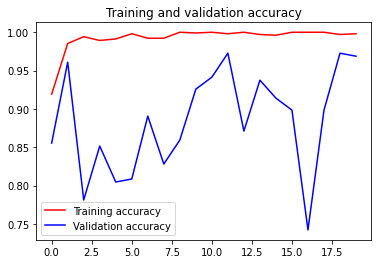

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model.save("mymodel.h5")